# Estresse concentrado em n buraco circular

Modelagem computacional do comportamento da tensão concentrada sobre n buracos circulares em uma placa.

### Importar pacotes

In [1048]:
import numpy as np
import matplotlib.pyplot as plt

### Parâmetros

In [1049]:
# Estresse aplicado em MPa
sigma = 100

# Raio do buraco em mm
radius = 20

# Distancia entre os furos em mm
distance_between_holes =  int(radius / 2)

# Número de furos
n_holes = 4

Posição dos furos

In [1050]:
center_spacing = radius * 2 + distance_between_holes

length_used = (n_holes - 1) * center_spacing + radius * 2
start = - length_used / 2 + radius

holes_x = [start + index * center_spacing for index in range(n_holes)]

### Gerar malha de grade

In [1051]:
width = n_holes * radius * 2 + (n_holes - 1) * distance_between_holes

start_x = - (int(width / 2) + 100)
end_x = (int(width / 2) + 100)
density_x = (abs(start_x) + abs(end_x)) * 2

start_y = - (2 * radius + 30)
end_y = (2 * radius + 30)
density_y = (abs(start_y) + abs(end_y)) * 2

x = np.linspace(start_x, end_x, density_x)
y = np.linspace(start_y, end_y, density_y)
X, Y = np.meshgrid(x, y)

### Computa as distâncias radiais e ângulos para os buracos

In [1052]:
def compute_radial_distance(position_x):
  return np.sqrt((X - position_x)**2 + Y**2)

def compute_angles(position_x):
  return np.arctan2(Y, X - position_x)

rn = np.array(list((compute_radial_distance(position_x) for position_x in holes_x)))
theta_n = np.array(list((compute_angles(position_x) for position_x in holes_x)))

### Computa o campo de estresse ao redor dos buracos

Calcula as componentes de tensões

In [1053]:
def compute_radial_stress(r, theta):
  return (sigma / 2) * (1 - radius**2 / r**2) + (sigma / 2) * (1 + 3 * radius**4 / radius**4 - 4 * radius**2 / radius**2) * np.cos(2 * theta)

In [1054]:
def compute_shear_stress(r, theta):
  return - (sigma / 2) * (1 - 3 * radius**4 / r**4 + 2 * radius**2 / r**2) * np.sin(2 * theta)

In [1055]:
def compute_theta_stress(r, theta):
  return (sigma / 2) * (1 + radius**2 / r**2) - (sigma / 2) * (1 + 3 * radius**4 / r**4) * np.cos(2 * theta)

In [1056]:
T_radial = np.array(list((compute_radial_stress(rn[index], theta_n[index]) for index in range(n_holes))))
T_shear = np.array(list((compute_shear_stress(rn[index], theta_n[index]) for index in range(n_holes))))
T_theta = np.array(list((compute_theta_stress(rn[index], theta_n[index]) for index in range(n_holes))))

Calcula as tensões de interação entre os buracos

In [1057]:
def compute_radial_hole_interaction(theta):
  return (sigma * radius**2 / distance_between_holes**2) * np.cos(2 * theta)

In [1058]:
def compute_shear_hole_interaction(theta):
  return (sigma * radius**2 / distance_between_holes**2) * np.sin(2 * theta)

In [1059]:
def compute_theta_hole_interaction(theta):
  return - (sigma * radius**2 / distance_between_holes**2) * np.cos(2 * theta)

In [1060]:
radial_holes_interactions = np.array(list((compute_radial_hole_interaction(theta_n[index]) for index in range(n_holes))))
shear_holes_interactions = np.array(list((compute_shear_hole_interaction(theta_n[index]) for index in range(n_holes))))
theta_holes_interactions = np.array(list((compute_theta_hole_interaction(theta_n[index]) for index in range(n_holes))))

Calcula a tensão total

In [1061]:
T_superposition = np.sum(T_radial, axis=0) + np.sum(T_shear, axis=0) + np.sum(T_theta, axis=0)

In [1062]:
T_interactions = np.sum(radial_holes_interactions, axis=0) + np.sum(shear_holes_interactions, axis=0) + np.sum(theta_holes_interactions, axis=0)

In [1063]:
T_total = T_superposition + T_interactions if n_holes > 1 else T_superposition

Exclui as tensões dentro do buraco

In [1064]:
for index in range(n_holes):
  T_total[rn[index] < radius] = np.nan

In [1065]:
T_total

array([[1175.49267387, 1177.55446975, 1179.62163853, ..., -667.81046974,
        -666.33097544, -664.85248024],
       [1170.25043691, 1172.3119008 , 1174.37883742, ..., -663.88529249,
        -662.4008121 , -660.91744981],
       [1164.97717574, 1167.03812018, 1169.10463633, ..., -659.92569371,
        -658.43639033, -656.94832374],
       ...,
       [-656.94832374, -658.43639033, -659.92569371, ..., 1169.10463633,
        1167.03812018, 1164.97717574],
       [-660.91744981, -662.4008121 , -663.88529249, ..., 1174.37883742,
        1172.3119008 , 1170.25043691],
       [-664.85248024, -666.33097544, -667.81046974, ..., 1179.62163853,
        1177.55446975, 1175.49267387]])

### Gráfico de tensões totais

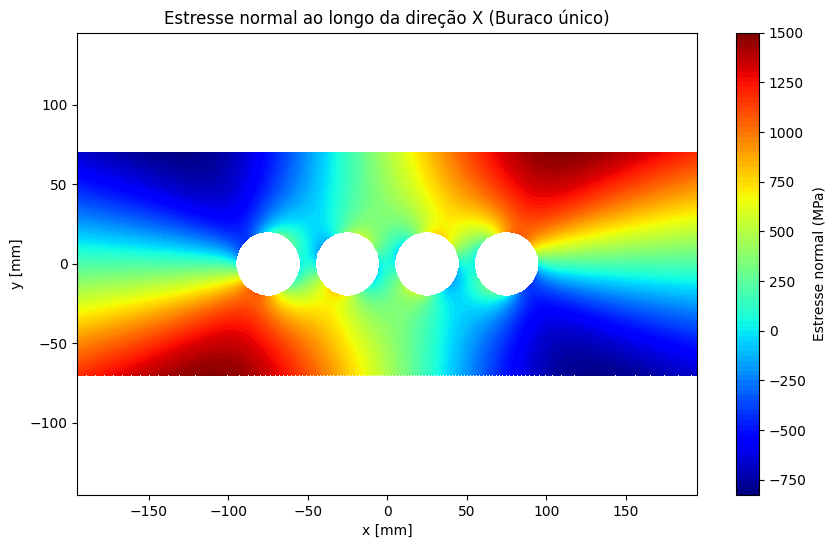

In [1066]:
plt.figure(figsize=(10, 6))
contour = plt.contourf(X, Y, T_total, levels=100, cmap='jet')
plt.colorbar(contour, label='Estresse normal (MPa)')
plt.title('Estresse normal ao longo da direção X (Buraco único)')
plt.xlabel('x [mm]')
plt.ylabel('y [mm]')
plt.axis('equal')
plt.grid(False)

### Gráfico de tensão radial

In [1067]:
T_radial_only = np.sum(T_radial, axis=0) + np.sum(radial_holes_interactions, axis=0) if (n_holes > 1) else np.sum(T_radial, axis=0)

for index in range(n_holes):
  T_radial_only[rn[index] < radius] = np.nan

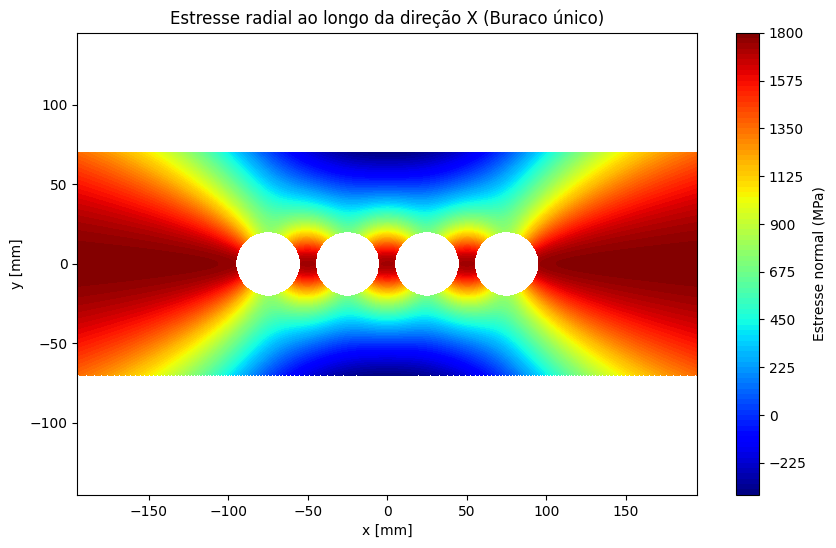

In [1068]:
plt.figure(figsize=(10, 6))
contour = plt.contourf(X, Y, T_radial_only, levels=100, cmap='jet')
plt.colorbar(contour, label='Estresse normal (MPa)')
plt.title('Estresse radial ao longo da direção X (Buraco único)')
plt.xlabel('x [mm]')
plt.ylabel('y [mm]')
plt.axis('equal')
plt.grid(False)

### Gráfico da tensão cisalhante

In [1069]:
T_shear_only = np.sum(T_shear, axis=0) + np.sum(shear_holes_interactions, axis=0) if (n_holes > 1) else np.sum(T_shear, axis=0)

for index in range(n_holes):
  T_shear_only[rn[index] < radius] = np.nan

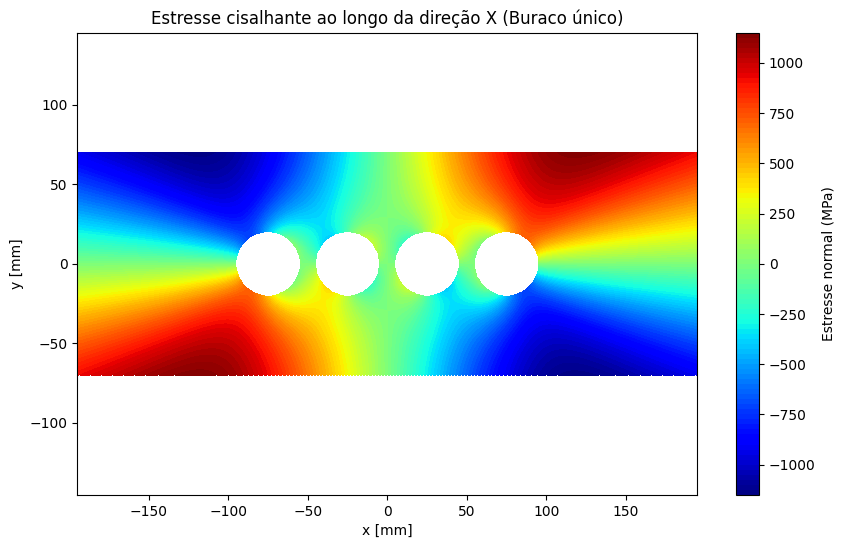

In [1070]:
plt.figure(figsize=(10, 6))
contour = plt.contourf(X, Y, T_shear_only, levels=100, cmap='jet')
plt.colorbar(contour, label='Estresse normal (MPa)')
plt.title('Estresse cisalhante ao longo da direção X (Buraco único)')
plt.xlabel('x [mm]')
plt.ylabel('y [mm]')
plt.axis('equal')
plt.grid(False)

### Gráfico de tensão circunferêncial

In [1071]:
T_theta_only = np.sum(T_theta, axis=0) + np.sum(theta_holes_interactions, axis=0) if (n_holes > 1) else np.sum(T_theta, axis=0)

for index in range(n_holes):
  T_theta_only[rn[index] < radius] = np.nan

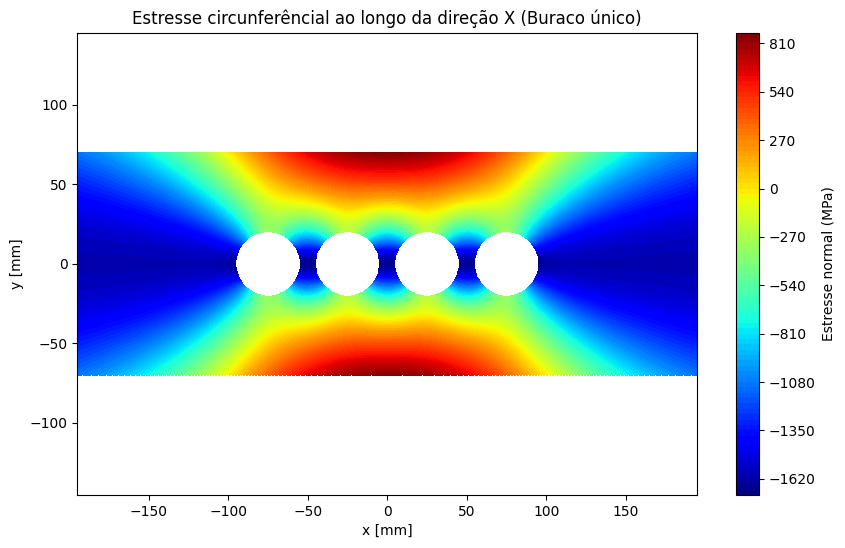

In [1072]:
plt.figure(figsize=(10, 6))
contour = plt.contourf(X, Y, T_theta_only, levels=100, cmap='jet')
plt.colorbar(contour, label='Estresse normal (MPa)')
plt.title('Estresse circunferêncial ao longo da direção X (Buraco único)')
plt.xlabel('x [mm]')
plt.ylabel('y [mm]')
plt.axis('equal')
plt.grid(False)